In [1]:
import numpy as np
import torch

In [4]:
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [10]:
transform = transforms.ToTensor() # Conversão de imagem para tensor

trainset = datasets.MNIST('./MNIST_data', download=True, 
               train=True, transform=transform) # Carrega o dataset de treino
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data', download=True, 
                        train=False, transform=transform) # Carrega parte da validação
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True)

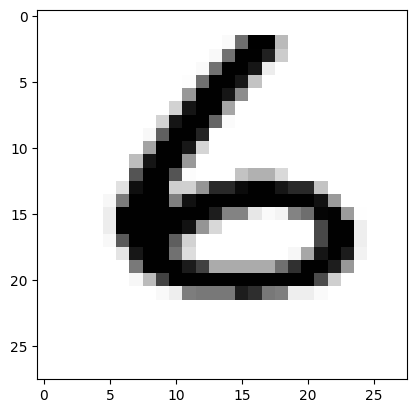

In [18]:
dataiter = iter(trainloader)

imagens, etiquetas = next(dataiter)
plt.imshow(imagens[0].numpy().squeeze(), cmap='gray_r')
plt.show()

In [20]:
print(imagens[0].shape)
print(etiquetas[0].shape)

torch.Size([1, 28, 28])
torch.Size([])


In [21]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128) # Camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64) # Camada interna 1, 128 neurônios que se ligam 64
        self.linear3 = nn.Linear(64, 10) # Camada interna 2 64 neurônios que se ligam a 10
        # Para a camada de saída não é necessário definir nada, pois só precisamos pegar o output da camada interna 2

    def forward(self, X):
        X = F.relu(self.linear1(X)) # funcao de ativação da camada de entrada para 1
        X = F.relu(self.linear2(X)) # funcao de ativação da camada interna 1 para 2
        X = self.linear3(X) # função de ativação da camada interna 2

        return F.log_softmax(X, dim=1) # Dados utilizados para calcular a perda

In [22]:
def treino(modelo, trainloader, device):
    # Definindo o otimizador
    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)
    
    # Timer para saber quanto tempo levou o treino
    inicio = time()
    
    # Critério para calcular a perda
    criterio = nn.NLLLoss()
    
    # Número de epochs
    EPOCHS = 10
    
    # Ativando o modo de treinamento do modelo
    modelo.train()
    
    for epoch in range(EPOCHS):
        perda_acumulada = 0  # Inicializando a perda acumulada da epoch em questão
        
        for imagens, etiquetas in trainloader:
            # Convertendo as imagens para formato vetorial
            imagens = imagens.view(imagens.shape[0], -1)
            # Zerando os gradientes do ciclo anterior
            otimizador.zero_grad()
            # Colocando os dados no modelo
            output = modelo(imagens.to(device))
            # Calculando a perda
            perda_instantanea = criterio(output, etiquetas.to(device))
            
            # Backpropagation
            perda_instantanea.backward()
            
            # Atualizando os pesos e bias
            otimizador.step()
            
            # Acumulando a perda
            perda_acumulada += perda_instantanea.item()
        
        # Exibindo as estatísticas de cada epoch
        print(f"Epoch {epoch+1}/{EPOCHS}, Perda: {perda_acumulada:.4f}")
    
    # Calculando o tempo total de treinamento
    print(f"Treinamento concluído em {time() - inicio:.2f} segundos.")


In [23]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0
    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):
            img = imagens[i].view(1, 784)  # Redimensionando a imagem
            
            # Desativar o autograd para acelerar a validação. Grafos computacionais dinâmicos têm um custo alto
            with torch.no_grad():
                logps = modelo(img.to(device))  # Output do modelo em escala logarítmica
            
            ps = torch.exp(logps)  # Converte output para escala normal (lembre-se que é um tensor)
            probab = list(ps.cpu().numpy()[0])  # Converte o tensor para lista de probabilidades
            etiqueta_pred = probab.index(max(probab))  # Índice com maior probabilidade
            etiqueta_certa = etiquetas.numpy()[i]  # Etiqueta correta
            
            # Compara a previsão com o valor correto
            if etiqueta_certa == etiqueta_pred:
                conta_corretas += 1
            conta_todas += 1
    
    print("Total de imagens testadas =", conta_todas)
    print("\nPrecisão do modelo = {}".format(conta_corretas * 100 / conta_todas))

In [24]:
modelo = Modelo()

#device = torch.divice()

#modelo.to(divice)

In [ ]:
modelo.train